### Purpose of Notebook: build model to predict whether or not a premier league match will have a score greater than 2 (or 2.5 as the bettings firms classify the cutoff point)

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson,skellam
#from astropy.stats import boostrap
%matplotlib inline
pd.set_option('display.max_columns', 75)
plt.style.use('seaborn')

In [150]:
# import scraping packages
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [151]:
# pull data and explore
df = pd.read_csv("season-1819.csv")
df2 = pd.read_csv("season-1718.csv")

# create total score field, which will need for binary label
df['total_score'] = (df.FTHG + df.FTAG)
df2['total_score'] = (df2.FTHG + df2.FTAG)

# get overview of dataframes
print('18-19 df info and head:\n')
df.info()
df.head()
df.describe()

print('\n18-19 df info and head:\n')
df2.info()
df2.head()
df2.describe()

18-19 df info and head:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 23 columns):
Date           269 non-null object
HomeTeam       269 non-null object
AwayTeam       269 non-null object
FTHG           269 non-null int64
FTAG           269 non-null int64
FTR            269 non-null object
HTHG           269 non-null int64
HTAG           269 non-null int64
HTR            269 non-null object
Referee        269 non-null object
HS             269 non-null int64
AS             269 non-null int64
HST            269 non-null int64
AST            269 non-null int64
HF             269 non-null int64
AF             269 non-null int64
HC             269 non-null int64
AC             269 non-null int64
HY             269 non-null int64
AY             269 non-null int64
HR             269 non-null int64
AR             269 non-null int64
total_score    269 non-null int64
dtypes: int64(17), object(6)
memory usage: 48.4+ KB


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score
0,2018-08-10,Man United,Leicester,2,1,H,1,0,H,A Marriner,8,13,6,4,11,8,2,5,2,1,0,0,3
1,2018-08-11,Bournemouth,Cardiff,2,0,H,1,0,H,K Friend,12,10,4,1,11,9,7,4,1,1,0,0,2
2,2018-08-11,Fulham,Crystal Palace,0,2,A,0,1,A,M Dean,15,10,6,9,9,11,5,5,1,2,0,0,2
3,2018-08-11,Huddersfield,Chelsea,0,3,A,0,2,A,C Kavanagh,6,13,1,4,9,8,2,5,2,1,0,0,3
4,2018-08-11,Newcastle,Tottenham,1,2,A,1,2,A,M Atkinson,15,15,2,5,11,12,3,5,2,2,0,0,3


,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score
count,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000
mean,1.553903,1.278810,0.695167,0.594796,14.178439,10.899628,4.884758,3.977695,10.568773,10.427509,5.732342,4.513011,1.542751,1.713755,0.055762,0.085502,2.832714
std,1.338952,1.165565,0.883099,0.793708,5.962393,4.248920,2.699798,2.267442,3.198634,3.607536,2.906971,2.736708,1.219797,1.238317,0.229889,0.280148,1.615540
min,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,3.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,2.000000,8.000000,8.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,2.000000
50%,1.000000,1.000000,0.000000,0.000000,14.000000,10.000000,5.000000,4.000000,10.000000,10.000000,5.000000,4.000000,1.000000,2.000000,0.000000,0.000000,3.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,13.000000,6.000000,6.000000,13.000000,13.000000,8.000000,6.000000,2.000000,2.000000,0.000000,0.000000,4.000000
max,6.000000,6.000000,4.000000,3.000000,36.000000,25.000000,14.000000,12.000000,23.000000,21.000000,14.000000,13.000000,6.000000,5.000000,1.000000,1.000000,8.000000



18-19 df info and head:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 23 columns):
Date           380 non-null object
HomeTeam       380 non-null object
AwayTeam       380 non-null object
FTHG           380 non-null int64
FTAG           380 non-null int64
FTR            380 non-null object
HTHG           380 non-null int64
HTAG           380 non-null int64
HTR            380 non-null object
Referee        380 non-null object
HS             380 non-null int64
AS             380 non-null int64
HST            380 non-null int64
AST            380 non-null int64
HF             380 non-null int64
AF             380 non-null int64
HC             380 non-null int64
AC             380 non-null int64
HY             380 non-null int64
AY             380 non-null int64
HR             380 non-null int64
AR             380 non-null int64
total_score    380 non-null int64
dtypes: int64(17), object(6)
memory usage: 68.4+ KB


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score
0,2017-08-11,Arsenal,Leicester,4,3,H,2,2,D,M Dean,27,6,10,3,9,12,9,4,0,1,0,0,7
1,2017-08-12,Brighton,Man City,0,2,A,0,0,D,M Oliver,6,14,2,4,6,9,3,10,0,2,0,0,2
2,2017-08-12,Chelsea,Burnley,2,3,A,0,3,A,C Pawson,19,10,6,5,16,11,8,5,3,3,2,0,5
3,2017-08-12,Crystal Palace,Huddersfield,0,3,A,0,2,A,J Moss,14,8,4,6,7,19,12,9,1,3,0,0,3
4,2017-08-12,Everton,Stoke,1,0,H,1,0,H,N Swarbrick,9,9,4,1,13,10,6,7,1,1,0,0,1


,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,1.531579,1.147368,0.607895,0.515789,13.584211,10.855263,4.626316,3.763158,10.218421,10.478947,5.739474,4.544737,1.478947,1.565789,0.044737,0.057895,2.678947
std,1.340087,1.177793,0.793403,0.756511,5.771439,4.858700,2.706845,2.317015,3.256360,3.336388,2.993047,2.767241,1.256993,1.259639,0.219375,0.233852,1.665125
min,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,9.000000,7.000000,3.000000,2.000000,8.000000,8.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,10.500000,4.000000,3.500000,10.000000,10.000000,5.000000,4.000000,1.000000,1.000000,0.000000,0.000000,3.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,14.000000,6.000000,5.000000,12.000000,13.000000,8.000000,6.000000,2.000000,2.000000,0.000000,0.000000,4.000000
max,7.000000,6.000000,4.000000,3.000000,35.000000,30.000000,15.000000,14.000000,19.000000,26.000000,18.000000,13.000000,6.000000,7.000000,2.000000,1.000000,9.000000


# first look at goal distribution

In [152]:
# creating hist plotting function, 
# overlay with poisson pmf, common distribution for sports goals
def hagoal_plot(df=df, title='#Goals/Match', 
                bin_field=['FTHG','FTAG'], 
                hist_label=['Home', 'Away'], 
                set_alpha=0.5,
                goal_max=10):
    """function to create the home/away goal histogram with poisson pmf overlay"""
    
    pos_pred = np.column_stack([[poisson.pmf(i, df[bin_field].mean()[j]) for i in range(goal_max)] 
                                    for j in range(len(bin_field))])

    # poisson pmf lines
    if len(bin_field) == 2:
        plt.hist(df[bin_field].values, range(10), 
                  alpha=set_alpha, label=hist_label,
                  density=True, color=['r', 'b'])
        _pois_1 = plt.plot([i-0.5 for i in range(1,goal_max+1)], pos_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = 'r')
        _pois2, = plt.plot([i-0.5 for i in range(1,goal_max+1)], pos_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = 'b')
    else:
        plt.hist(df[bin_field].values, range(10), 
                 alpha=set_alpha, label=hist_label,density=True, color=['r'])
        _pois_1 = plt.plot([i-0.5 for i in range(1,goal_max+1)], pos_pred[:,0],
                  linestyle='-', marker='o',label="Total Score", color = 'r')

    plt.xticks([i-0.5 for i in range(1,goal_max+1)],[i for i in range(10)])
    leg=plt.legend(loc='upper right', fontsize=15, ncol=2)
    leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})
    plt.xlabel("#Goals/Match",size=13)
    plt.ylabel("% of Matches",size=13)
    plt.title(title, size=14, fontweight='bold')
    plt.ylim([-0.004, 0.4])
    plt.tight_layout()
    plt.show() 

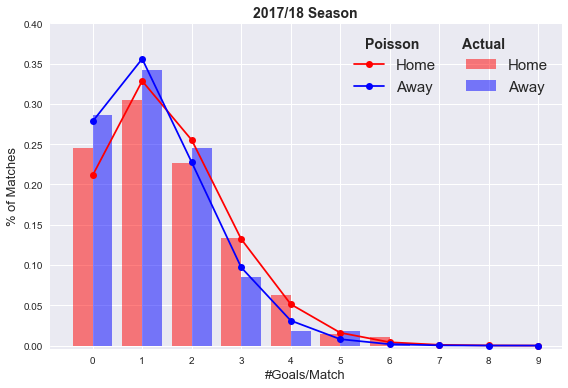

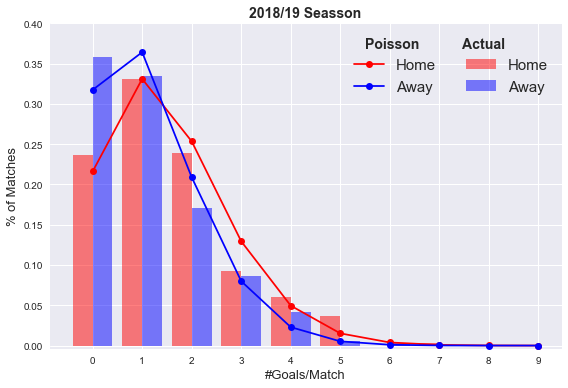

In [153]:
# run goal plotting function on 2017/18 and 2017/18 seasons and combined
hagoal_plot(df=df, title='2017/18 Season')
hagoal_plot(df=df2, title='2018/19 Seasson')

### ^^^ Looks like home/away goals hist follow quite closely to their relative poisson pmfs

In [154]:
# create total score field, which will be label/y value of model
df_total = pd.concat([df, df2], ignore_index=True)
print('18-19 df info and head:\n')
df_total.info()
df_total.head()

18-19 df info and head:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 23 columns):
Date           649 non-null object
HomeTeam       649 non-null object
AwayTeam       649 non-null object
FTHG           649 non-null int64
FTAG           649 non-null int64
FTR            649 non-null object
HTHG           649 non-null int64
HTAG           649 non-null int64
HTR            649 non-null object
Referee        649 non-null object
HS             649 non-null int64
AS             649 non-null int64
HST            649 non-null int64
AST            649 non-null int64
HF             649 non-null int64
AF             649 non-null int64
HC             649 non-null int64
AC             649 non-null int64
HY             649 non-null int64
AY             649 non-null int64
HR             649 non-null int64
AR             649 non-null int64
total_score    649 non-null int64
dtypes: int64(17), object(6)
memory usage: 116.7+ KB


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score
0,2018-08-10,Man United,Leicester,2,1,H,1,0,H,A Marriner,8,13,6,4,11,8,2,5,2,1,0,0,3
1,2018-08-11,Bournemouth,Cardiff,2,0,H,1,0,H,K Friend,12,10,4,1,11,9,7,4,1,1,0,0,2
2,2018-08-11,Fulham,Crystal Palace,0,2,A,0,1,A,M Dean,15,10,6,9,9,11,5,5,1,2,0,0,2
3,2018-08-11,Huddersfield,Chelsea,0,3,A,0,2,A,C Kavanagh,6,13,1,4,9,8,2,5,2,1,0,0,3
4,2018-08-11,Newcastle,Tottenham,1,2,A,1,2,A,M Atkinson,15,15,2,5,11,12,3,5,2,2,0,0,3


In [155]:
# now lets look at the mean of the home/away goals
df[['FTHG','FTAG']].mean()
df2[['FTHG','FTAG']].mean()
df_total[['FTHG','FTAG']].mean()

# now look at variance
np.var(df[['FTHG','FTAG']])
np.var(df2[['FTHG','FTAG']])
np.var(df_total[['FTHG','FTAG']])

# for reference in poisson distribution the
# expected value = variance

FTHG    1.553903
FTAG    1.278810
dtype: float64

FTHG    1.531579
FTAG    1.147368
dtype: float64

FTHG    1.540832
FTAG    1.201849
dtype: float64

FTHG    1.786128
FTAG    1.353492
dtype: float64

FTHG    1.791108
FTAG    1.383546
dtype: float64

FTHG    1.789165
FTAG    1.375282
dtype: float64

#### ^^ the variance looks pretty close to its mean counterpart so it appears that this is from a poisson distibution. 

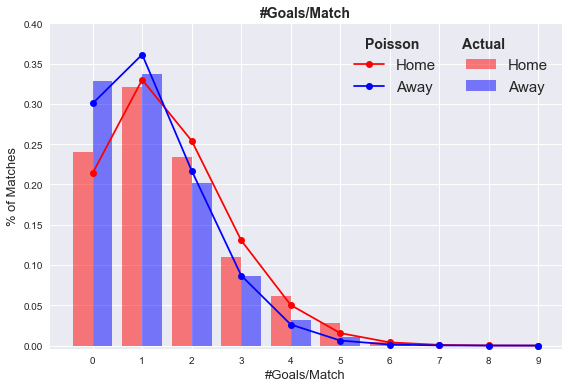

In [156]:
hagoal_plot(df=df_total)

### ^^^ both seasons combined also follows closely to the poisson

## Now lets do the same plotting exercise but for total goals 

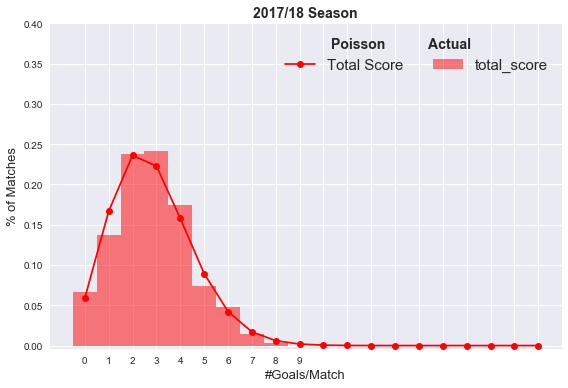

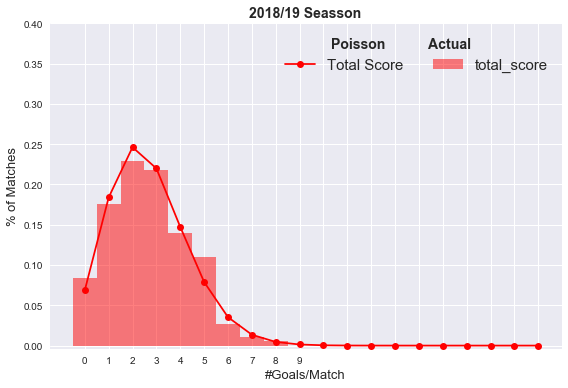

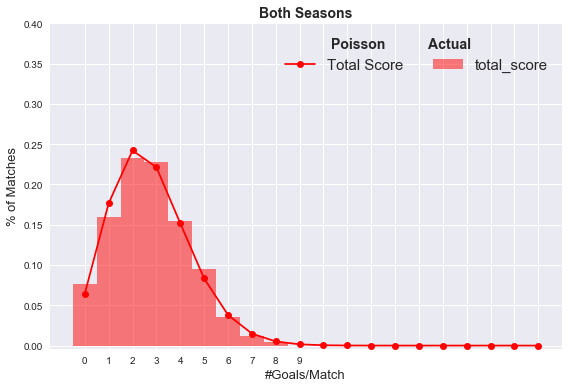

In [157]:
hagoal_plot(df=df, title='2017/18 Season', 
            bin_field=['total_score'], 
            hist_label=['total_score'],
            goal_max = 20)
hagoal_plot(df=df2, title='2018/19 Seasson',
            bin_field=['total_score'],
            hist_label=['total_score'],
            goal_max = 20)
hagoal_plot(df=df_total, title='Both Seasons', 
            bin_field=['total_score'],
            hist_label=['total_score'],
            goal_max = 20)

In [158]:
df['total_score'].mean()
df2['total_score'].mean()
df_total['total_score'].mean()

2.83271375464684

2.6789473684210527

2.7426810477657937

In [159]:
# now lets look at the mean of the home/away goals
df['total_score'].mean()
df2['total_score'].mean()
df_total['total_score'].mean()

# now look at variance
np.var(df['total_score'])
np.var(df2['total_score'])
np.var(df_total['total_score'])

# for reference in poisson distribution the
# expected value = variance

2.83271375464684

2.6789473684210527

2.7426810477657937

2.600268100219732

2.7653462603878114

2.7026621494250964

#### ^^ the variance for total score also looks pretty close to its mean counterpart so it appears that this is from a poisson distibution. 

### now lets set up our binary y variable for classification/binary regression prep

### we are going to use the combined data of 2017 through the current 2018/19 season and use days/months from match date to current date as a field in our future classifier

In [160]:
df_total['y'] = df_total['total_score'].apply(lambda x: 1 if x > 2.5 else 0)
df_total.info()
df_total.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 24 columns):
Date           649 non-null object
HomeTeam       649 non-null object
AwayTeam       649 non-null object
FTHG           649 non-null int64
FTAG           649 non-null int64
FTR            649 non-null object
HTHG           649 non-null int64
HTAG           649 non-null int64
HTR            649 non-null object
Referee        649 non-null object
HS             649 non-null int64
AS             649 non-null int64
HST            649 non-null int64
AST            649 non-null int64
HF             649 non-null int64
AF             649 non-null int64
HC             649 non-null int64
AC             649 non-null int64
HY             649 non-null int64
AY             649 non-null int64
HR             649 non-null int64
AR             649 non-null int64
total_score    649 non-null int64
y              649 non-null int64
dtypes: int64(18), object(6)
memory usage: 121.8+ KB


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score,y
0,2018-08-10,Man United,Leicester,2,1,H,1,0,H,A Marriner,8,13,6,4,11,8,2,5,2,1,0,0,3,1
1,2018-08-11,Bournemouth,Cardiff,2,0,H,1,0,H,K Friend,12,10,4,1,11,9,7,4,1,1,0,0,2,0
2,2018-08-11,Fulham,Crystal Palace,0,2,A,0,1,A,M Dean,15,10,6,9,9,11,5,5,1,2,0,0,2,0
3,2018-08-11,Huddersfield,Chelsea,0,3,A,0,2,A,C Kavanagh,6,13,1,4,9,8,2,5,2,1,0,0,3,1
4,2018-08-11,Newcastle,Tottenham,1,2,A,1,2,A,M Atkinson,15,15,2,5,11,12,3,5,2,2,0,0,3,1
5,2018-08-11,Watford,Brighton,2,0,H,1,0,H,J Moss,19,6,5,0,10,16,8,2,2,2,0,0,2,0
6,2018-08-11,Wolves,Everton,2,2,D,1,1,D,C Pawson,11,6,4,5,8,7,3,6,0,1,0,1,4,1
7,2018-08-12,Arsenal,Man City,0,2,A,0,1,A,M Oliver,9,17,3,8,11,14,2,9,2,2,0,0,2,0
8,2018-08-12,Liverpool,West Ham,4,0,H,2,0,H,A Taylor,18,5,8,2,14,9,5,4,1,2,0,0,4,1
9,2018-08-12,Southampton,Burnley,0,0,D,0,0,D,G Scott,18,16,3,6,10,9,8,5,0,1,0,0,0,0


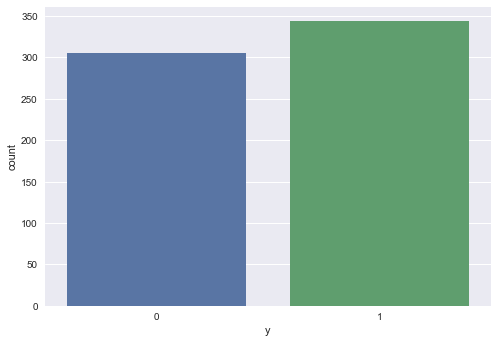

In [163]:
sns.countplot(x='y', data=df_total)
plt.show()